In [9]:
# --- Step 1: Import Libraries and Load Data ---

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

# Import necessary libraries from scikit-learn and TensorFlow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
# Import EarlyStopping to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping

# --- Data Loading ---
print("Please upload your 'control_surface_vibrations_100k.csv' file.")
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

print("\nDataset shape:", df.shape)
print("First 5 rows of the dataset:")
print(df.head())

Please upload your 'control_surface_vibrations_100k.csv' file.


Saving control_surface_vibration_modes_100k.csv to control_surface_vibration_modes_100k (1).csv

Dataset shape: (100000, 10)
First 5 rows of the dataset:
  Surface_Type     Material  Length_m  Width_m  Thickness_m  Airspeed_mps  \
0       Rudder     Titanium      1.93     0.28        0.020         174.6   
1       Rudder  CarbonFiber      1.00     0.49        0.027         219.1   
2     Elevator     Titanium      1.40     0.44        0.025          93.5   
3     Elevator  CarbonFiber      1.63     0.29        0.010         179.5   
4      Aileron     Titanium      1.64     0.38        0.029         195.9   

   Angle_of_Attack_deg  Mode_Number  Natural_Freq_Hz  Damping_Ratio  
0                 13.5            3            15.27          0.031  
1                 11.8            1            12.60          0.026  
2                  8.4            3            17.54          0.038  
3                 -4.2            3            14.80          0.034  
4                  1.6           

In [10]:
# --- Step 2: Define Features (X) and Targets (y) ---

# One-hot encode categorical features if they exist
if 'Surface_Type' in df.columns and 'Material' in df.columns:
    df = pd.get_dummies(df, columns=['Surface_Type', 'Material'], drop_first=True)
    print("\nDataset shape after one-hot encoding:", df.shape)

target_cols = ['Natural_Freq_Hz', 'Damping_Ratio']
X = df.drop(columns=target_cols)
y = df[target_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Dataset shape after one-hot encoding: (100000, 12)


In [11]:
# --- Step 3: Scale Features and Targets ---

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [12]:
# --- Step 4: Reshape Features for LSTM Input ---

X_train_stacked = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_stacked = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [13]:
# --- Step 5: Define an Enhanced Regression Model ---

model = Sequential()

# Increased neurons for more capacity
model.add(LSTM(128, activation='tanh', return_sequences=True,
               input_shape=(X_train_stacked.shape[1], X_train_stacked.shape[2])))
model.add(Dropout(0.2))

# Increased neurons
model.add(LSTM(64, activation='tanh'))
model.add(Dropout(0.2))

# Increased neurons
model.add(Dense(32, activation='relu'))

# Output layer remains the same
model.add(Dense(2, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

print("\nEnhanced Stacked LSTM Regression Model Summary:")
model.summary()


Enhanced Stacked LSTM Regression Model Summary:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 1, 128)         │        71,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,722 (479.38 KB)

 Trainable params: 122,722 (479.38 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# --- Step 6: Train the Model with Early Stopping ---

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=50,          # Stop after 50 epochs of no improvement
    restore_best_weights=True # Restore the best model weights
)

print("\n--- Starting Model Training ---")
history = model.fit(
    X_train_stacked,
    y_train_scaled,
    epochs=50,          # Increased epochs
    batch_size=128,     # Reduced batch size
    validation_data=(X_test_stacked, y_test_scaled),
    callbacks=[early_stopping], # Add the callback here
    verbose=1
)
print("--- Model Training Finished ---")


--- Starting Model Training ---
Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0030 - mae: 0.0360 - val_loss: 0.0031 - val_mae: 0.0362
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0030 - mae: 0.0355 - val_loss: 0.0030 - val_mae: 0.0374
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0030 - mae: 0.0354 - val_loss: 0.0030 - val_mae: 0.0377
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0030 - mae: 0.0351 - val_loss: 0.0030 - val_mae: 0.0385
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0029 - mae: 0.0348 - val_loss: 0.0030 - val_mae: 0.0381
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0030 - mae: 0.0347 - val_loss: 0.0030 - val_mae: 0.0383
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0030 - mae: 0.0347 - val_loss: 0.0031 - val_mae: 0.0393
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0029 - mae: 0.0346 - val_loss: 0.0031 - val_mae: 0.0386
Epoch 9/50
625/625 


--- Evaluating Model Performance ---

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
--- R-squared (Performance Score) ---
Natural_Freq_Hz R-squared: 0.9890 (Explains 98.90% of the variance)
Damping Ratio R-squared: 0.8014 (Explains 80.14% of the variance)

--- Sample of Actual vs. Predicted Values ---
   Actual Natural_Freq_Hz  Predicted Natural_Freq_Hz  Actual Damping_Ratio  Predicted Damping_Ratio
0                   11.56                  11.925920                 0.032                 0.034988
1                   10.30                  10.637063                 0.026                 0.025059
2                   16.42                  16.224005                 0.026                 0.024884
3                    8.17                   8.766006                 0.026                 0.025148
4                   14.76                  14.723102                 0.026                 0.024946
5                   17.80                  17.458227                 0.029                 0.029892
6

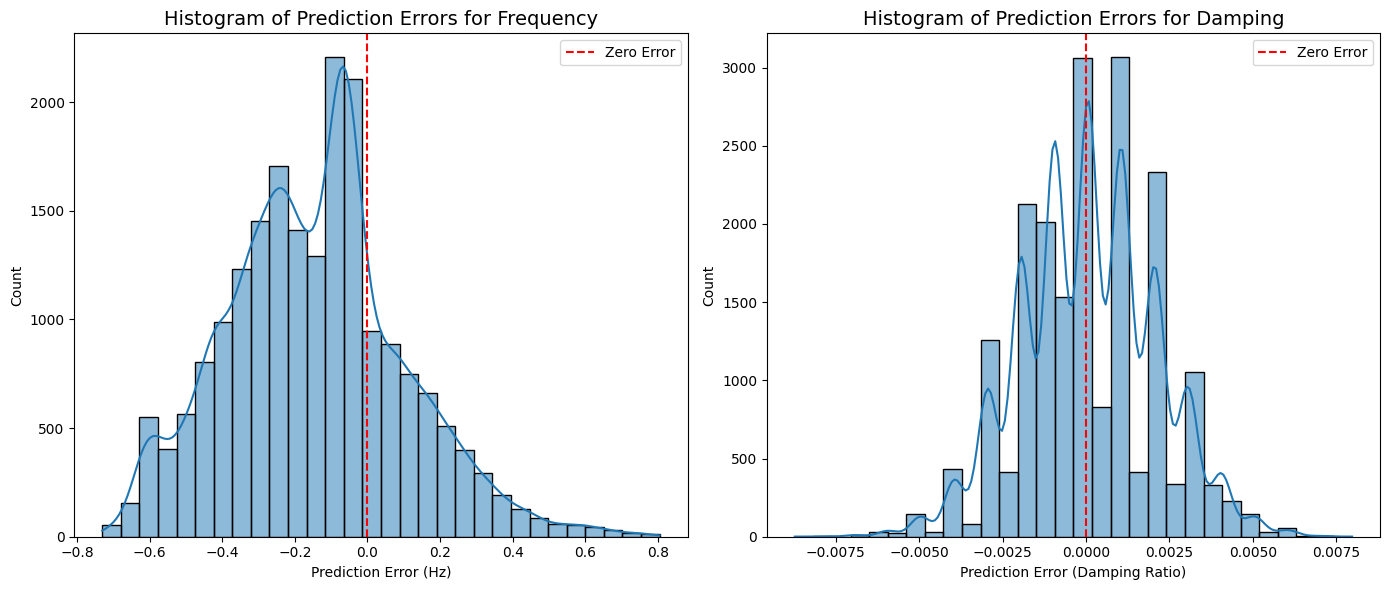

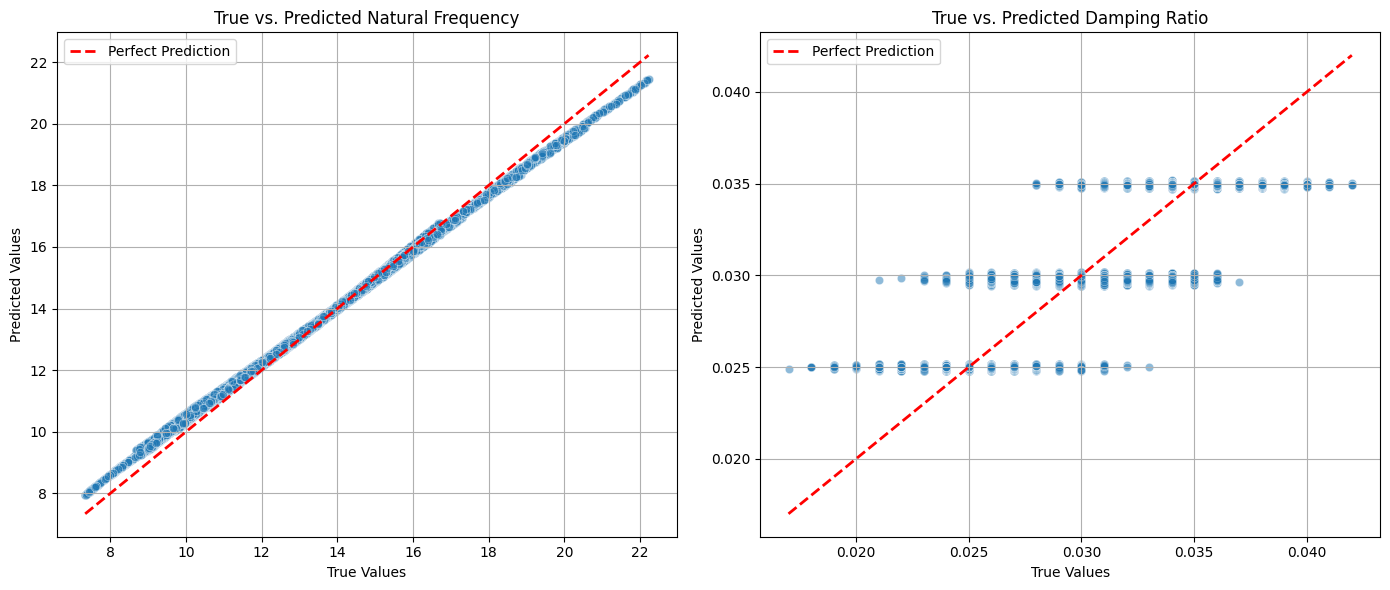

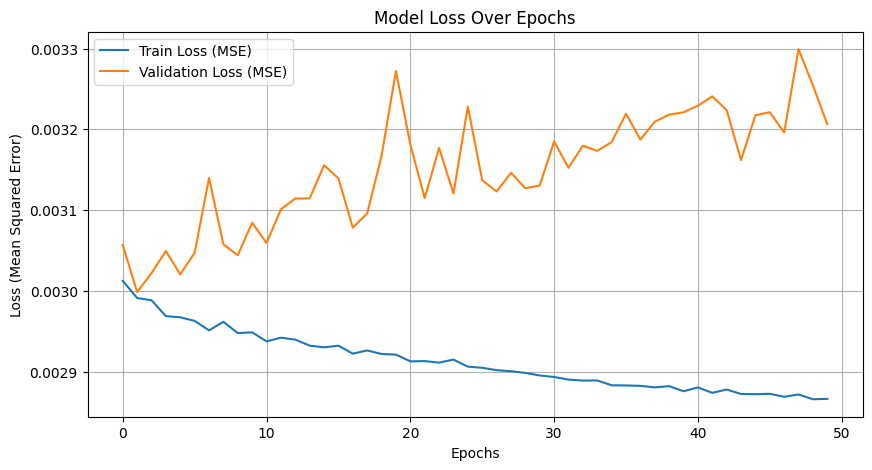

In [20]:
# --- Step 7: Evaluate Performance and Add Histogram Plot ---

print("\n--- Evaluating Model Performance ---\n")

# Predict and inverse transform the predictions
y_pred_scaled = model.predict(X_test_stacked)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

# --- R-squared (Performance Score) ---
print("--- R-squared (Performance Score) ---")
r2_freq = r2_score(y_test['Natural_Freq_Hz'], y_pred[:, 0])
r2_damp = r2_score(y_test['Damping_Ratio'], y_pred[:, 1])
print(f"Natural_Freq_Hz R-squared: {r2_freq:.4f} (Explains {r2_freq*100:.2f}% of the variance)")
print(f"Damping Ratio R-squared: {r2_damp:.4f} (Explains {r2_damp*100:.2f}% of the variance)")

# --- Sample of Actual vs. Predicted Values ---
print("\n--- Sample of Actual vs. Predicted Values ---")
results_df = pd.DataFrame({
    'True_Freq': y_test['Natural_Freq_Hz'].values,
    'Predicted_Freq': y_pred[:, 0],
    'True_Damping': y_test['Damping_Ratio'].values,
    'Predicted_Damping': y_pred[:, 1]
})
# Use a cleaner name for printing to match your desired format exactly
print_df = results_df.rename(columns={
    'True_Freq': 'Actual Natural_Freq_Hz',
    'Predicted_Freq': 'Predicted Natural_Freq_Hz',
    'True_Damping': 'Actual Damping_Ratio',
    'Predicted_Damping': 'Predicted Damping_Ratio'
})
print(print_df.head(10).to_string())

# --- NEW: Calculate Prediction Errors and Plot Histogram ---
# Calculate the errors (residuals) for each target variable.
results_df['Freq_Error'] = results_df['True_Freq'] - results_df['Predicted_Freq']
results_df['Damping_Error'] = results_df['True_Damping'] - results_df['Predicted_Damping']

# Create histogram plots to visualize the distribution of errors.
# A good model should have errors centered around zero in a bell-like shape.
plt.figure(figsize=(14, 6))

# Histogram for Natural Frequency Error
plt.subplot(1, 2, 1)
sns.histplot(results_df['Freq_Error'], kde=True, bins=30)
plt.axvline(x=0, color='r', linestyle='--', label='Zero Error') # Line at zero for reference
plt.title('Histogram of Prediction Errors for Frequency', fontsize=14)
plt.xlabel('Prediction Error (Hz)')
plt.ylabel('Count')
plt.legend()

# Histogram for Damping Ratio Error
plt.subplot(1, 2, 2)
sns.histplot(results_df['Damping_Error'], kde=True, bins=30)
plt.axvline(x=0, color='r', linestyle='--', label='Zero Error') # Line at zero for reference
plt.title('Histogram of Prediction Errors for Damping', fontsize=14)
plt.xlabel('Prediction Error (Damping Ratio)')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()


# --- Visualizations (Scatter Plots and Loss Curves) ---
# These plots provide a visual confirmation of the performance metrics.
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
# Use the results_df for cleaner plotting
sns.scatterplot(data=results_df, x='True_Freq', y='Predicted_Freq', alpha=0.5)
plt.plot([results_df['True_Freq'].min(), results_df['True_Freq'].max()],
         [results_df['True_Freq'].min(), results_df['True_Freq'].max()], 'r--', lw=2, label='Perfect Prediction')
plt.title('True vs. Predicted Natural Frequency')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
# Use the results_df for cleaner plotting
sns.scatterplot(data=results_df, x='True_Damping', y='Predicted_Damping', alpha=0.5)
plt.plot([results_df['True_Damping'].min(), results_df['True_Damping'].max()],
         [results_df['True_Damping'].min(), results_df['True_Damping'].max()], 'r--', lw=2, label='Perfect Prediction')
plt.title('True vs. Predicted Damping Ratio')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.grid(True)
plt.show()